In [24]:
import torch
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [12]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_dim):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 120)
        self.fc2 = nn.Linear(120, 64)
        self.fc3 = nn.Linear(64, 4)

    def forward(self, x):
        x = torch.sigmoid(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        x = self.fc3(x)

        return x

In [5]:
data = pd.read_csv('D:/Coding/Github/automatic_parking/vision_assisted_autonomous_parking/datasets/dataset_completo.csv')
x = data.iloc[:, :719].values.astype(dtype=np.float32)
y = data.iloc[:, 720].values.astype(dtype=np.int64) 
feature_index = list(range(0,719))
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [8]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

select_k_best = SelectKBest(mutual_info_classif, k=100)
X_train_k_best = select_k_best.fit_transform(X_train_scaled, y_train)
X_test_k_best = select_k_best.transform(X_test_scaled)

selected_features_indices = select_k_best.get_support(indices=True)

np.savetxt('D:/Coding/Github/automatic_parking/vision_assisted_autonomous_parking/Pytorch/k_best_selected_features/selected_features.csv', selected_features_indices, delimiter=',', fmt='%d')

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

xs_train = torch.tensor(X_train_k_best).view(-1, len(X_train_k_best[0])).to(device)
ys_train = torch.tensor(y_train).to(device)
xs_test = torch.tensor(X_test_k_best).view(-1, len(X_test_k_best[0])).to(device)
ys_test = torch.tensor(y_test).to(device)

In [33]:
mean = torch.mean(xs_train, dim=0)
std_dev = torch.std(xs_train, dim=0)
mean_broadcasted = mean.unsqueeze(0).expand_as(xs_train)
std_dev_broadcasted = std_dev.unsqueeze(0).expand_as(xs_train)
xs_train_z_score = (xs_train - mean_broadcasted) / std_dev_broadcasted
mean_broadcasted = mean.unsqueeze(0).expand_as(xs_test)
std_dev_broadcasted = std_dev.unsqueeze(0).expand_as(xs_test)
xs_test_z_score = (xs_test - mean_broadcasted) / std_dev_broadcasted

In [10]:
max_value = 12
min_value = 0

xs_train_min_max = (xs_train - min_value)/(max_value - min_value)
xs_test_min_max = (xs_test - min_value)/(max_value - min_value)

In [20]:
model = NeuralNetwork(len(xs_train_min_max[0]))
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

batch_size = 500
torch.manual_seed(42)
dataset = TensorDataset(xs_train_min_max,ys_train)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


In [21]:
# Train the model
num_epochs = 2000
loss_per_epoch = []
for epoch in range(num_epochs):
    for batch_idx, (xs_batch, ys_batch) in enumerate(dataloader):
        outputs = model(xs_batch)
        loss = criterion(outputs, ys_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if(epoch % 100 == 0):
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}')
        loss_per_epoch.append(loss.item())

print('Training finished.')

Epoch [1/2000], Loss: 1.382838487625122
Epoch [101/2000], Loss: 0.412960022687912
Epoch [201/2000], Loss: 0.37563908100128174
Epoch [301/2000], Loss: 0.3271750509738922
Epoch [401/2000], Loss: 0.29007673263549805
Epoch [501/2000], Loss: 0.3392976224422455
Epoch [601/2000], Loss: 0.33383244276046753
Epoch [701/2000], Loss: 0.390262246131897
Epoch [801/2000], Loss: 0.33361637592315674
Epoch [901/2000], Loss: 0.30296000838279724
Epoch [1001/2000], Loss: 0.3671116530895233
Epoch [1101/2000], Loss: 0.34814780950546265
Epoch [1201/2000], Loss: 0.3406045734882355
Epoch [1301/2000], Loss: 0.33836326003074646
Epoch [1401/2000], Loss: 0.3539371192455292
Epoch [1501/2000], Loss: 0.34898024797439575
Epoch [1601/2000], Loss: 0.3737637400627136
Epoch [1701/2000], Loss: 0.3357873857021332
Epoch [1801/2000], Loss: 0.3225648105144501
Epoch [1901/2000], Loss: 0.3353516459465027
Training finished.


In [22]:
with torch.no_grad():
    outputs = model(xs_test_min_max)
# Metrics calculation (optional)
_, predicted = torch.max(outputs, 1)
accuracy = (predicted == ys_test).sum().item() / ys_test.size(0)
# Calculate other metrics as needed

print(f"Loss: {loss.item()}")
print(f"Accuracy: {accuracy}")

Loss: 0.28026777505874634
Accuracy: 0.6801204819277108


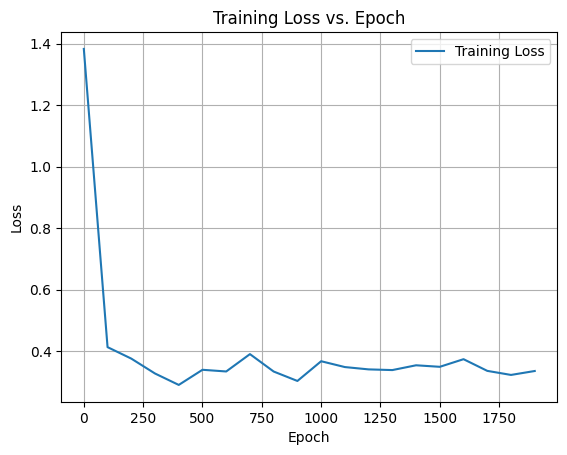

In [26]:
plt.plot(range(0,2000,100), loss_per_epoch, label='Training Loss')
plt.title('Training Loss vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()

In [28]:
model.eval()
with torch.no_grad():
    predicted_value = model(torch.tensor(xs_test_min_max[0]).to(device))
print("Input Feature: " + str(xs_test_min_max[0]))
print("Expected Value: " + str(ys_test[0]))
print("Model Output: " + str(predicted_value))
print("Model Prediction: " + str(torch.argmax(predicted_value)))

Input Feature: tensor([-0.0526, -0.0584, -0.0561, -0.0421, -0.0412, -0.0356, -0.0430, -0.0466,
        -0.0519, -0.0546, -0.0547, -0.0538, -0.0574, -0.0593, -0.0586, -0.0592,
        -0.0666, -0.0679, -0.0635, -0.0617, -0.0585, -0.0600, -0.0546, -0.0647,
        -0.0656, -0.0635, -0.0634, -0.0714, -0.0714, -0.0714, -0.0723, -0.0813,
        -0.0698, -0.0799, -0.0785, -0.0957, -0.0932, -0.0801, -0.0546,  0.0619,
         0.0581,  0.0573,  0.0574,  0.0568,  0.0577,  0.0576,  0.0575,  0.0544,
         0.0543,  0.0615,  0.0629,  0.0601,  0.0559,  0.0546,  0.0492,  0.0456,
         0.0461,  0.0468,  0.0469,  0.0475,  0.0467,  0.0479,  0.0489,  0.0483,
         0.0442,  0.0411,  0.0414,  0.0432,  0.0444,  0.0454,  0.0451,  0.0481,
         0.0478,  0.0488,  0.0515,  0.0542,  0.0581,  0.0587,  0.0600,  0.0035,
         0.0067,  0.0019, -0.0083, -0.0092, -0.0146, -0.0197, -0.0230, -0.0305,
        -0.0352, -0.0372, -0.0455, -0.0539, -0.0559, -0.0549, -0.0546, -0.0576,
        -0.0623, -0.0604,

C:\Users\gsoch\AppData\Local\Temp\ipykernel_6960\3084701899.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predicted_value = model(torch.tensor(xs_test_min_max[0]).to(device))


In [30]:
torch.save(model.state_dict(), 'D:/Coding/Github/automatic_parking/vision_assisted_autonomous_parking/Pytorch/model/model_final.pth')

In [21]:
model = NeuralNetwork(len(xs_train_z_score[0]))
model.load_state_dict(torch.load('datasets/model1.pth'))
model.eval()

NeuralNetwork(
  (fc1): Linear(in_features=10, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=3, bias=True)
)

In [24]:
with torch.no_grad():
    predicted_value = model(torch.tensor(xs_test[400]).to(device))
print("Input Feature: " + str(xs_test[400]))
print("Expected Value: " + str(ys_test[400]))
print("Model Prediction: " + str(torch.argmax(predicted_value)))

Input Feature: tensor([-1.0493, -1.2094, -1.3192, -1.3859, -1.0902, -1.0788, -1.5170, -1.0826,
        -1.0960, -0.9731])
Expected Value: tensor(1)
Model Prediction: tensor(1)


C:\Users\gsoch\AppData\Local\Temp\ipykernel_7860\1364314063.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predicted_value = model(torch.tensor(xs_test[400]).to(device))
